# Proyek Klasifikasi Gambar: [Indonesian Wayang (Traditional Puppet Show)]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [5]:
import zipfile
import os

# Tentukan path file ZIP yang ada di Google Drive
local_zip = r'D:\.CITRA\Notebook 1st Commit\Notebook 1st Commit\labeled-indonesian-wayang-fixed.zip'  # Ganti dengan path file ZIP kamu

# Tentukan lokasi ekstraksi
extract_to = r'D:\.CITRA\Notebook 1st Commit'

# Ekstrak file ZIP
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset berhasil diekstrak ke {extract_to}")

Dataset berhasil diekstrak ke D:\.CITRA\Notebook 1st Commit


In [6]:
# import shutil
# import os

# # Path folder bermasalah
# base_path = '/content/wayang/labeled-indonesian-wayang-fixed/labeled-indonesian-wayang-fixed'
# # Path folder yang seharusnya
# target_path = '/content/wayang/labeled-indonesian-wayang-fixed'

# # List semua subfolder di base_path
# subfolders = os.listdir(base_path)

# for subfolder in subfolders:
#     source = os.path.join(base_path, subfolder)
#     destination = os.path.join(target_path, subfolder)
#     shutil.move(source, destination)

# # Hapus folder kosong setelah dipindahkan
# os.rmdir(base_path)

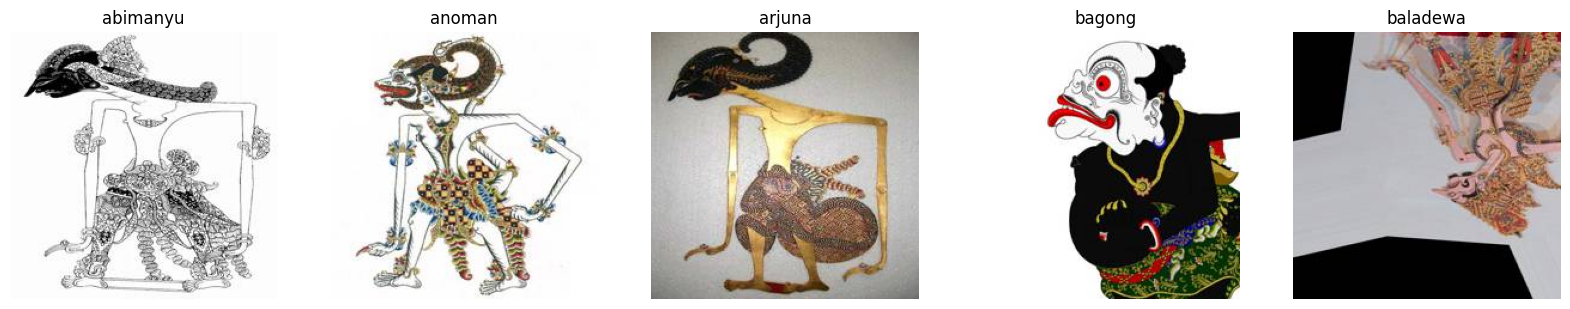

In [7]:
# Tentukan folder tempat dataset gambar diekstrak
dataset_dir = r'D:\.CITRA\Notebook 1st Commit\labeled-indonesian-wayang-fixed'  # Ganti dengan path ekstraksi datasetmu
# List folder (label) dalam dataset
labels = os.listdir(dataset_dir)

# Menampilkan beberapa gambar pertama dari dataset
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

# Loop untuk menampilkan gambar dari 5 label pertama
for i, label in enumerate(labels[:5]):  # Menampilkan 5 label pertama
    label_path = os.path.join(dataset_dir, label)

    # Menyaring hanya file gambar, bukan folder
    image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]

    if image_files:  # Jika ada file gambar dalam folder
        img_path = os.path.join(label_path, image_files[0])  # Mengambil gambar pertama
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label)

plt.show()

In [8]:
# Menghitung jumlah data per label
labels_list = []

# Menyusun daftar semua label berdasarkan gambar dalam folder
for label in labels:
    label_path = os.path.join(dataset_dir, label)
    image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    labels_list.extend([label] * len(image_files))  # Menambahkan label sesuai jumlah gambar

# Menghitung jumlah data per label
label_counts = pd.Series(labels_list).value_counts()

# Menampilkan jumlah data per label dalam bentuk teks
print("Total Jumlah Label:", len(label_counts))
print("Persebaran Data per Label:")
print(label_counts)

Total Jumlah Label: 22
Persebaran Data per Label:
abimanyu         480
anoman           480
bima             480
baladewa         480
cakil            480
buta             480
sengkuni         480
togog            480
durna            480
dursasana        480
gareng           480
karna            480
patih_sabrang    480
kresna           480
semar            480
puntadewa        480
arjuna           479
bagong           479
gatotkaca        479
duryudana        479
petruk           479
nakula_sadewa    478
Name: count, dtype: int64


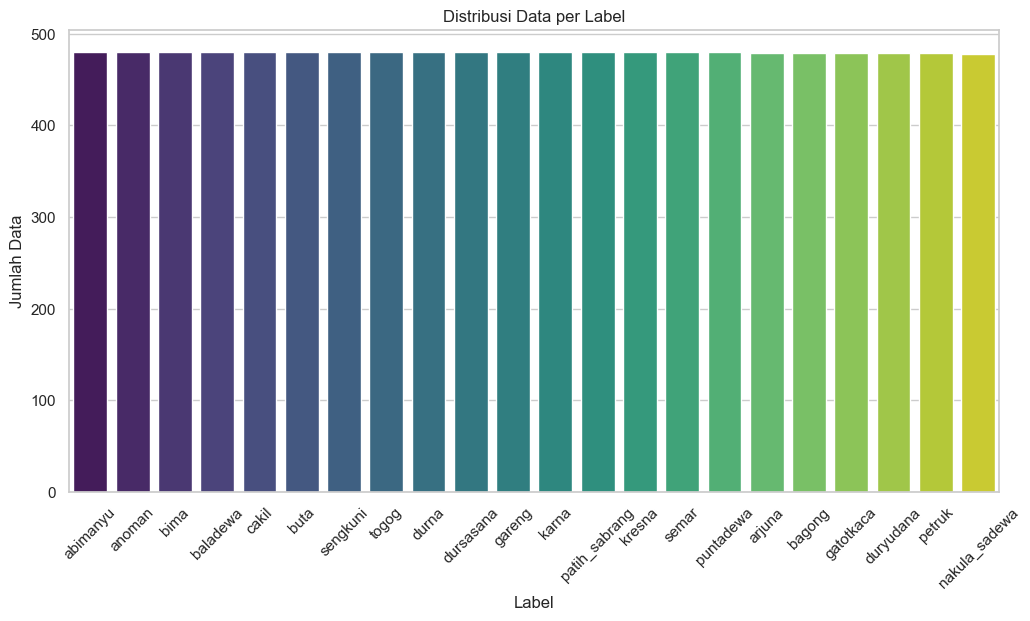

In [9]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot distribusi data per label
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Menambahkan label dan judul
plt.title("Distribusi Data per Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)  # Rotasi label sumbu X 45 derajat

# Menampilkan plot
plt.show()

### Data Preprocessing

#### Resize dan Normalisasi

In [10]:
from tqdm import tqdm

def resize_and_save_images(source_dir, target_dir, target_size=(224, 224)):
    # Kalau folder target belum ada, buat
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop semua folder label
    labels = os.listdir(source_dir)
    for label in tqdm(labels, desc='Resizing folders'):
        label_path = os.path.join(source_dir, label)
        target_label_path = os.path.join(target_dir, label)

        if not os.path.exists(target_label_path):
            os.makedirs(target_label_path)

        if os.path.isdir(label_path):  # Pastikan itu folder, bukan file
            images = os.listdir(label_path)
            for image_file in tqdm(images, desc=f'Resizing {label}', leave=False):
                if image_file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                    img_path = os.path.join(label_path, image_file)
                    img = Image.open(img_path).convert('RGB')  # Convert supaya tidak error mode
                    img_resized = img.resize(target_size)

                    save_path = os.path.join(target_label_path, image_file)
                    img_resized.save(save_path)

# Example usage:
source_dataset_dir = r'D:\.CITRA\Notebook 1st Commit\labeled-indonesian-wayang-fixed'
target_dataset_dir = r'D:\.CITRA\Notebook 1st Commit\wayang-resized'  # Folder hasil resize

resize_and_save_images(source_dataset_dir, target_dataset_dir, target_size=(224, 224))

Resizing folders: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


#### Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset hasil resize
dataset_fix = r'D:\.CITRA\Notebook 1st Commit\wayang-resized'

# Buat ImageDataGenerator + augmentasi + split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Train Generator
train_generator = datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator (augmentasi biasa hanya rescale)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 8448 images belonging to 22 classes.
Found 2111 images belonging to 22 classes.


#### Split Dataset

In [12]:
# Buat 1 datagen untuk training dan validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.4  # 30% dibagi validation + test
)

# Train generator (70% data)
train_generator = datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Untuk validation/test, buat datagen baru tanpa augmentasi
test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5
)

# Validation generator (15% data)
val_generator = test_val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test generator (ambil validation lagi dengan shuffle=False untuk evaluasi final)
test_generator = test_val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Test set jangan di-shuffle
)


Found 6336 images belonging to 22 classes.
Found 5279 images belonging to 22 classes.
Found 5279 images belonging to 22 classes.


In [13]:
print(f"Jumlah data training: {train_generator.samples}")
print(f"Jumlah data validation: {val_generator.samples}")
print(f"Jumlah data test: {test_generator.samples}")

Jumlah data training: 6336
Jumlah data validation: 5279
Jumlah data test: 5279
